## 1. Importing the Libraries

In [1]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import numpy as np
import sklearn 
import tensorflow as tf
import tensorflow.keras.optimizers as Optimizer
import matplotlib.pyplot as plt
import os




In [2]:
# first connect to mount drive
%cd /content/drive/MyDrive/Projects/IntelImageClassification

/content/drive/MyDrive/Projects/IntelImageClassification


In [3]:
from fetch_dataset import load_traindata, load_valdata, process
from utils import test_prediction, test_data_for_matrix, plot_accuracy, plot_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Prefetch and Tuning in Tensorflow

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

## 3. Data Loading

* You might be using flow_from_directory along with ImageDataGenerator() to set up the dataset, but they aren't compatible with tf.data.AUTOTUNE. Use tf.keras.preprocessing.image_dataset_from_directory instead to load the dataset.

In [5]:
image_size = (224,224)
checkpoint_filepath = os.path.join('checkpoint/')

batch_size = 32
train_ds = load_traindata(batch_size, image_size)
val_ds = load_valdata(batch_size, image_size)

#train_ds = train_ds.map(process)
#val_ds = val_ds.map(process)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## 4. Model Architecture and Transfer learning

In [6]:
def create_model(image_size):
    image_shape = image_size + (3,)    

    base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_shape, classes=6)
    base_model.trainable=False

    '''base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
    
    inputs = tf.keras.Input(shape=image_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(6, activation = 'Softmax' )(x)
    model = tf.keras.Model(inputs, outputs)'''

    model = Models.Sequential()
    model.add(base_model)
    model.add(Layers.GlobalAveragePooling2D())
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(6, activation='softmax'))

    return model

model = create_model(image_size)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


## 5. Model compile and Learning rate Rescheduling

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.0001),
    (5, 0.00001),
    (10, 0.000005)
]


def lr_schedule(epoch, lr):
    
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

lr_scheduler_on_pretrained = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=2)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True)

## 6. Model Training

In [35]:
history = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds,
                    verbose = 1,
                    callbacks = [lr_scheduler_on_pretrained, model_checkpoint_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
439/439 [==============================] - 1392s 3s/step - loss: 1.0669 - accuracy: 0.6189 - val_loss: 0.6098 - val_accuracy: 0.8297

Epoch 00001: val_accuracy improved from -inf to 0.82967, saving model to checkpoint/
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
439/439 [==============================] - 32s 73ms/step - loss: 0.5410 - accuracy: 0.8315 - val_loss: 0.4240 - val_accuracy: 0.8633

Epoch 00002: val_accuracy improved from 0.82967 to 0.86333, saving model to checkpoint/
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
439/439 [==============================] - 32s 74ms/step - loss: 0.4162 - accuracy: 0.8593 - val_loss: 0.3562 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.86333 to 0.87500, saving model to checkpoint/
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rat

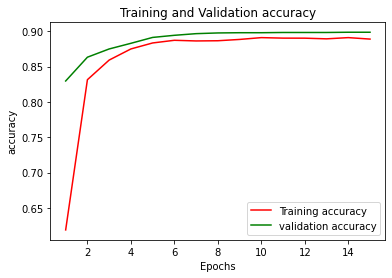

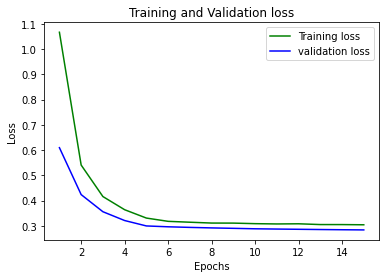

In [36]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])
plot_loss(history.history['loss'], history.history['val_loss'])

In [9]:
test_img, test_label = test_data_for_matrix(val_ds)

In [10]:
model.load_weights(checkpoint_filepath)

In [12]:
confusion,report = test_prediction(model, test_img, test_label)

In [13]:
print(confusion)

[[390   0   0   0   3  44]
 [  0 471   0   2   1   0]
 [  3   1 428  94  24   3]
 [  0   0  66 452   5   2]
 [  3   1   7   4 490   5]
 [ 31   1   0   2   2 465]]


In [14]:
print(report)

              precision    recall  f1-score   support

           0      0.913     0.892     0.903       437
           1      0.994     0.994     0.994       474
           2      0.854     0.774     0.812       553
           3      0.816     0.861     0.838       525
           4      0.933     0.961     0.947       510
           5      0.896     0.928     0.912       501

    accuracy                          0.899      3000
   macro avg      0.901     0.902     0.901      3000
weighted avg      0.899     0.899     0.898      3000

